# FIT5202 Assignment 2
## Rain in Australia: Predict rain tomorrow in Australia
 **Haichen Wang** <br>
 **29212634**
<br>

## A.Creating Spark Session and Loading the Data

### Step 01: Import Spark Session and initialize Spark
Write the code to create a sparkSession object, with 4 local cores.

In [1]:
# import required library
from pyspark import SparkContext
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, when, count, avg
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from collections import Counter
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# initialize Spark
sc = SparkContext.getOrCreate()

if (sc is None):
    sc = SparkContext(master="local[4]", appName="Rain Predictor")
spark = SparkSession(sparkContext=sc)

### Step 02: Load the dataset and print the schema and total number of entries
In ​sparkSession, use ​`spark_session.read.csv()` method to load data as CSV format. <br>
After loading the csv file into a dataframe using spark session, write the code to print the total number of entries in the dataset. 

In [3]:
# load data
df = spark.read.csv("weatherAUS.csv", inferSchema=True, header=True)

print("Total Entries: {}".format(df.count()))
df.printSchema()

Total Entries: 142193
root
 |-- Date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- Evaporation: string (nullable = true)
 |-- Sunshine: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- Cloud9am: string (nullable = true)
 |-- Cloud3pm: string (nullable = true)
 |-- Temp9am: string (nullable = true)
 |-- Temp3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



## B. Data Cleaning and Processing

### Step 03: Delete columns from the dataset
Delete unnecessary data from the dataset to improve the efficiency and accuracy of model.

In [4]:
# drop unnecessary data
df_clean = df.drop('Date', 'Location', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3am')

df_clean.show(n=1, vertical=True)

-RECORD 0---------------
 MinTemp       | 13.4   
 MaxTemp       | 22.9   
 Rainfall      | 0.6    
 WindGustDir   | W      
 WindGustSpeed | 44     
 WindDir9am    | W      
 WindDir3pm    | WNW    
 WindSpeed9am  | 20     
 WindSpeed3pm  | 24     
 Humidity9am   | 71     
 Humidity3pm   | 22     
 Pressure9am   | 1007.7 
 Pressure3pm   | 1007.1 
 Temp3pm       | 21.8   
 RainToday     | No     
 RainTomorrow  | No     
only showing top 1 row



### Step 04: Print the number of missing data in each column
Print the number of NA(null) values in each column

In [5]:
# count 'NA' for each column
exprs_na = [count(when(col(c) == 'NA', 'NA')).alias(c) for c in df_clean.columns]
print("'NA' in each column:")
df_clean.agg(*exprs_na).show(vertical=True)

'NA' in each column:
-RECORD 0--------------
 MinTemp       | 637   
 MaxTemp       | 322   
 Rainfall      | 1406  
 WindGustDir   | 9330  
 WindGustSpeed | 9270  
 WindDir9am    | 10013 
 WindDir3pm    | 3778  
 WindSpeed9am  | 1348  
 WindSpeed3pm  | 2630  
 Humidity9am   | 1774  
 Humidity3pm   | 3610  
 Pressure9am   | 14014 
 Pressure3pm   | 13981 
 Temp3pm       | 2726  
 RainToday     | 1406  
 RainTomorrow  | 0     



### Step 05: Fill the missing data with average value and maximum occurrence value.
Firstly, identify the columns which have numeric values (e.g., MinTemp, MaxTemp), calculate the average and fill the null value with the average. <br>
Secondly, identify the columns with non-numeric values (e.g., WindGustDir, WindDir9am) and find the ​most ​frequent item (e.g., wind direction). <br> Fill the null values with that item for that particular column


In [6]:
# identify numeric values
numeric_cols = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', \
                'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm','Temp3pm']

# calculate average value
exprs_avg = [F.round(avg((col(c))),2).alias(c) for c in numeric_cols]
df_average = df_clean.agg(*exprs_avg)
df_average.show(vertical=True)

-RECORD 0----------------
 MinTemp       | 12.19   
 MaxTemp       | 23.23   
 Rainfall      | 2.35    
 WindGustSpeed | 39.98   
 WindSpeed9am  | 14.0    
 WindSpeed3pm  | 18.64   
 Humidity9am   | 68.84   
 Humidity3pm   | 51.48   
 Pressure9am   | 1017.65 
 Pressure3pm   | 1015.26 
 Temp3pm       | 21.69   



In [7]:
# method to replace 'NA' with average value for each column
def avg_replace(numeric_col):
    return F.when(df_clean[numeric_col] == 'NA', df_average.select(numeric_col).first()[0])\
            .otherwise(df_clean[numeric_col])

for column in numeric_cols:
    df_clean = df_clean.withColumn(column, avg_replace(column))

# show result
exprs_na = [count(when(col(c) == 'NA', 'NA')).alias(c) for c in df_clean.columns]
print("'NA' in each column:")
df_clean.agg(*exprs_na).show(vertical=True)

'NA' in each column:
-RECORD 0--------------
 MinTemp       | 0     
 MaxTemp       | 0     
 Rainfall      | 0     
 WindGustDir   | 9330  
 WindGustSpeed | 0     
 WindDir9am    | 10013 
 WindDir3pm    | 3778  
 WindSpeed9am  | 0     
 WindSpeed3pm  | 0     
 Humidity9am   | 0     
 Humidity3pm   | 0     
 Pressure9am   | 0     
 Pressure3pm   | 0     
 Temp3pm       | 0     
 RainToday     | 1406  
 RainTomorrow  | 0     



In [8]:
# identify non-numeric values
non_numeric_cols = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']

# intiate a collection for frequent values
dict_freq = {}

# calculate the most frequent value
for non_numeric_col in non_numeric_cols:
    col_list = df_clean.select(non_numeric_col).collect()
    most_freq_value = Counter(col_list).most_common(1)[0][0][0] # retrieve value from counter object
    dict_freq[non_numeric_col] = most_freq_value

print("Most Frequent Value:")
for key, value in dict_freq.items():
    print(key, '|', value)

Most Frequent Value:
WindGustDir | W
WindDir9am | N
WindDir3pm | SE
RainToday | No
RainTomorrow | No


In [9]:
# method to replace 'NA' with the most frequent value
def freq_replace(non_numeric_col):
    return F.when(df_clean[non_numeric_col] == 'NA', dict_freq.get(non_numeric_col)).otherwise(df_clean[non_numeric_col])

for column in non_numeric_cols:
    df_clean = df_clean.withColumn(column, freq_replace(column))

# show final result
exprs_na = [count(when(col(c) == 'NA', 'NA')).alias(c) for c in df_clean.columns]
print("'NA' in each column:")
df_clean.agg(*exprs_na).show(vertical=True)

'NA' in each column:
-RECORD 0------------
 MinTemp       | 0   
 MaxTemp       | 0   
 Rainfall      | 0   
 WindGustDir   | 0   
 WindGustSpeed | 0   
 WindDir9am    | 0   
 WindDir3pm    | 0   
 WindSpeed9am  | 0   
 WindSpeed3pm  | 0   
 Humidity9am   | 0   
 Humidity3pm   | 0   
 Pressure9am   | 0   
 Pressure3pm   | 0   
 Temp3pm       | 0   
 RainToday     | 0   
 RainTomorrow  | 0   



### Step 06: Data transformation
Cast numerical value columns into double. For the non-numerical value column (i.e., WindGustDir, WindDir9am, WindDir3pm, RainTomorrow) use the `StringIndexer` method to convert them into numbers.

In [10]:
# Cast numerical value columns into double
for column in numeric_cols:
    df_clean = df_clean.withColumn(column, col(column).cast(DoubleType()))

# convert non-numerical values into numbers
str_indexer = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in non_numeric_cols]
pipeline = Pipeline(stages=str_indexer)
pipelineModel = pipeline.fit(df_clean)
df_trans = pipelineModel.transform(df_clean)

# show result
df_ready =  df_trans.drop(*non_numeric_cols)
df_ready.printSchema()

root
 |-- MinTemp: double (nullable = true)
 |-- MaxTemp: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- WindGustSpeed: double (nullable = true)
 |-- WindSpeed9am: double (nullable = true)
 |-- WindSpeed3pm: double (nullable = true)
 |-- Humidity9am: double (nullable = true)
 |-- Humidity3pm: double (nullable = true)
 |-- Pressure9am: double (nullable = true)
 |-- Pressure3pm: double (nullable = true)
 |-- Temp3pm: double (nullable = true)
 |-- WindGustDir_index: double (nullable = false)
 |-- WindDir9am_index: double (nullable = false)
 |-- WindDir3pm_index: double (nullable = false)
 |-- RainToday_index: double (nullable = false)
 |-- RainTomorrow_index: double (nullable = false)



### Step 07: Create the feature vector and divide the dataset
Create the feature vector from the given columns, exclude the column for accuracy test. <br>
Spit the dataset randomly and between 70 percent and 30 percent.

In [11]:
# select input columns
select_cols = df_ready.columns
select_cols.remove("RainTomorrow_index")

# initiate vector assembler
vector_assembler = VectorAssembler(inputCols=select_cols,outputCol="Features")

# create feature vectors
df_temp = vector_assembler.transform(df_ready)
df_feature = df_temp.drop(*select_cols)
df_feature.show(n=1, truncate=False, vertical=True)

-RECORD 0-----------------------------------------------------------------------------------------
 RainTomorrow_index | 0.0                                                                         
 Features           | [13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,21.8,0.0,6.0,7.0,0.0] 
only showing top 1 row



In [12]:
# split the dataset between training and test dataset
# Use a seed to make the same data division
(trainingData, testData) = df_feature.randomSplit([0.7, 0.3], seed=1993)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 99765
Test Dataset Count: 42428


## C. Apply Machine Learning Algorithms

### Step 08: Apply machine learning classification algorithms on the dataset and compare their accuracy. Plot the accuracy as bar graph

Calculate the probability of the rain fall tomorrow based on the other related data points (e.g., temperature, wind, humidity) by:
- ​DecisionTreeClassifier()
- RandomForestClassifier()
- LogisticRegression()
- GBTClassifier()

Finally, draw the graph (e.g. bar chart) to demonstrate the comparison of their accuracy.

In [13]:
# initiate a collection to hold accuracy values for algorithms
# used for accuracy comparasion below
accuracy_collect = []

def multi_class_evaluate (prediction):
    
    """
    This function uses the MulticlassClassificationEvaluator to evaluate the accuracy of the model.
    """
    
    evaluator = MulticlassClassificationEvaluator(labelCol="RainTomorrow_index", \
                                                     predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(prediction)
    accuracy_collect.append(accuracy)
    print("Prediction Accuracy = {:.4%}".format(accuracy))

In [14]:
def print_predict_result (prediction, algorithm="algorithm"):
    
    """
    This function prints predition results.
    """
    
    print("\n Rain probability prediction via {}:\n".format(algorithm))
    prediction.select("prediction", "probability").filter(col('prediction') == 1).show(n=1, truncate=False)
    prediction.select("prediction").groupBy("prediction").count().show()
    prediction.select("RainTomorrow_index").groupBy("RainTomorrow_index").count().show()

In [15]:
# Decision Tree
# create model using the train set, predict with test set
dt = DecisionTreeClassifier(labelCol="RainTomorrow_index", featuresCol="Features")
dt_model = dt.fit(trainingData)
dt_prediction = dt_model.transform(testData)

# print result
print_predict_result(dt_prediction, 'decision tree')
# Use the MulticlassClassificationEvaluator to evaluate the accuracy of the model
multi_class_evaluate(dt_prediction)


 Rain probability prediction via decision tree:

+----------+----------------------------------------+
|prediction|probability                             |
+----------+----------------------------------------+
|1.0       |[0.32112068965517243,0.6788793103448276]|
+----------+----------------------------------------+
only showing top 1 row

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|37659|
|       1.0| 4769|
+----------+-----+

+------------------+-----+
|RainTomorrow_index|count|
+------------------+-----+
|               0.0|32935|
|               1.0| 9493|
+------------------+-----+

Prediction Accuracy = 83.6052%


In [16]:
# Random Forest
# create model using the train set, predict with test set
rf = RandomForestClassifier(labelCol="RainTomorrow_index", featuresCol="Features", numTrees=10)
rf_model = rf.fit(trainingData)
rf_prediction = rf_model.transform(testData)

# print result
print_predict_result(rf_prediction, 'random forest')
# Use the MulticlassClassificationEvaluator to evaluate accuracy
multi_class_evaluate(rf_prediction)


 Rain probability prediction via random forest:

+----------+---------------------------------------+
|prediction|probability                            |
+----------+---------------------------------------+
|1.0       |[0.3558600425800359,0.6441399574199641]|
+----------+---------------------------------------+
only showing top 1 row

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|38540|
|       1.0| 3888|
+----------+-----+

+------------------+-----+
|RainTomorrow_index|count|
+------------------+-----+
|               0.0|32935|
|               1.0| 9493|
+------------------+-----+

Prediction Accuracy = 83.1031%


In [17]:
# Logistic Regression
# create model using the train set, predict with test set
lr = LogisticRegression(labelCol="RainTomorrow_index", featuresCol="Features", maxIter=10)
lr_model = lr.fit(trainingData)
lr_prediction = lr_model.transform(testData)

# print result
print_predict_result(lr_prediction, 'logistic regression')
# Use the MulticlassClassificationEvaluator to evaluate accuracy
multi_class_evaluate(lr_prediction)


 Rain probability prediction via logistic regression:

+----------+----------------------------------------+
|prediction|probability                             |
+----------+----------------------------------------+
|1.0       |[0.39034215777582654,0.6096578422241735]|
+----------+----------------------------------------+
only showing top 1 row

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|36549|
|       1.0| 5879|
+----------+-----+

+------------------+-----+
|RainTomorrow_index|count|
+------------------+-----+
|               0.0|32935|
|               1.0| 9493|
+------------------+-----+

Prediction Accuracy = 81.4509%


In [18]:
# Gradient-boosted Tree
# create model using the train set, predict with test set
gbt = GBTClassifier(labelCol="RainTomorrow_index", featuresCol="Features", maxIter=10)
gbt_model = gbt.fit(trainingData)
gbt_prediction = gbt_model.transform(testData)

# print result
print_predict_result(gbt_prediction, 'gradient-boosted tree')
# Use the MulticlassClassificationEvaluator to evaluate accuracy
multi_class_evaluate(gbt_prediction)


 Rain probability prediction via gradient-boosted tree:

+----------+---------------------------------------+
|prediction|probability                            |
+----------+---------------------------------------+
|1.0       |[0.4970842842571642,0.5029157157428358]|
+----------+---------------------------------------+
only showing top 1 row

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|36618|
|       1.0| 5810|
+----------+-----+

+------------------+-----+
|RainTomorrow_index|count|
+------------------+-----+
|               0.0|32935|
|               1.0| 9493|
+------------------+-----+

Prediction Accuracy = 84.3429%


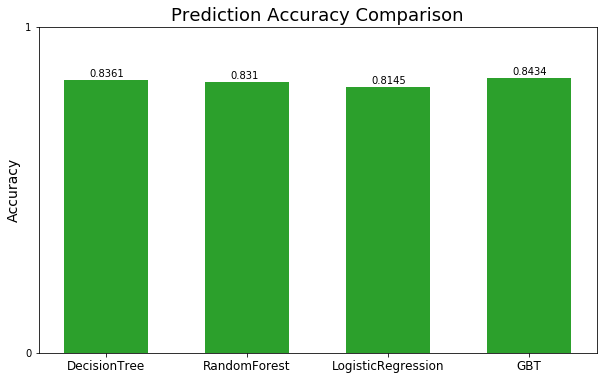

In [19]:
# present a figure for accuracy comparision
algorithms = ['DecisionTree', 'RandomForest', 'LogisticRegression', 'GBT']
accuracy_round = [round(a, 4) for a in accuracy_collect]

# plot configuration
plt.figure(figsize=(10,6))
plt.bar(algorithms, accuracy_round, width= 0.6, color="C2")
xlocs, xlabs = plt.xticks()
xlocs = [0,1,2,3]
xlabs = [i/2 for i in range(0,4)]
plt.xticks(fontsize=12)
plt.yticks(range(0,2))
plt.title('Prediction Accuracy Comparison',fontsize=18)
plt.ylabel('Accuracy', fontsize=14)

# configure text position on bars
for i, v in enumerate(accuracy_round):
    plt.text(xlocs[i] - 0.12, v + 0.01, str(v))
plt.show()

The figure above demonstrates accuracy comparison between algorithms evaluated via `MulticlassClassificationEvaluator`.<br>
The algorithm with higher score are considered better in acuracy. <br>
However, accuracy does not always represent the quality of the model, which should be known.

### Step 09: Calculate the confusion matrix and find the precision, recall, and F1 score of each classification algorithm. <br>
Explain how the accuracy of the predication can be improved

In [20]:
def print_stats(cm, precision, recall, f1Score, algorithm='algorithms'):

    """
    This function prints summary statistics.
    Including confusion matrix, precision, recall and f1Score.
    """

    print("\nSummary Stats - {}\n".format(algorithm))
    print("Precision = {}".format(precision))
    print("Recall = {}".format(recall))
    print("F1 Score = {}".format(f1Score))
    print("Confusion Matrix, without normalization")
    print(cm)

In [21]:
# visualisation method for confusion metrics
# Part of codes are referenced from
# https://runawayhorse001.github.io/LearningApacheSpark/classification.html

def plot_confusion_matrics(cm, classes=['no', 'yes'], normalize=False, title='Confusion matrix'):
    
    """
    This function plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    # normalisation    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # plot configuration
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title(title,fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    # configure text on matrics
    fmt = '.4f' if normalize else '.0f'
    thresh = cm.max()/2
    for i, j in [(0,0),(0,1),(1,0),(1,1)]:
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('RainTomorrow_index',fontsize=14)
    plt.xlabel('Prediction',fontsize=14)

    plt.show()

In [22]:
def run_stats(prediction, algorithm='algorithms'):
    
    """
    This function counts and presents confusion matrics and statistics
    for transferred predictions.
    """
    
    # Instantiate metrics object for decision tree
    prediction_label = prediction.select("prediction", "RainTomorrow_index").rdd.map(tuple)
    metrics = MulticlassMetrics(prediction_label)
    
    # Overall statistics
    cm = metrics.confusionMatrix().toArray()
    
    # specify label=1 for statisctics that predict rain tomorrow
    # also avoid spark returning results that precision = recall
    precision = metrics.precision(label=1)
    recall = metrics.recall(label=1)
    f1Score = 2*((precision*recall)/(precision+recall))
    
    # print statistics and draw confusion matrix
    print_stats(cm, precision, recall, f1Score, algorithm)
    plot_confusion_matrics(cm, normalize=True, title='Normalized Confusion Matrix')


Summary Stats - Decision Tree

Precision = 0.7659886768714615
Recall = 0.384809859896766
F1 Score = 0.5122703688122282
Confusion Matrix, without normalization
[[31819.  1116.]
 [ 5840.  3653.]]


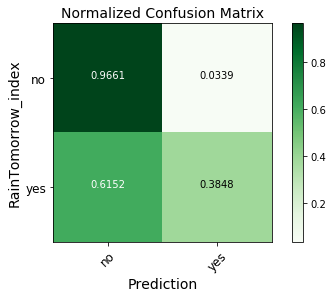


Summary Stats - Random Forest

Precision = 0.7988683127572016
Recall = 0.3271884546507953
F1 Score = 0.46424034078170545
Confusion Matrix, without normalization
[[32153.   782.]
 [ 6387.  3106.]]


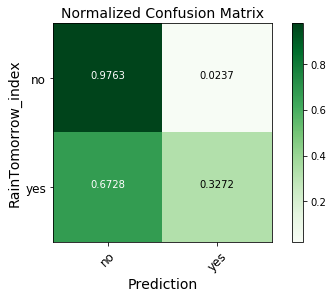


Summary Stats - Decision Tree

Precision = 0.6380336791971424
Recall = 0.3951332560834299
F1 Score = 0.48803018475149623
Confusion Matrix, without normalization
[[30807.  2128.]
 [ 5742.  3751.]]


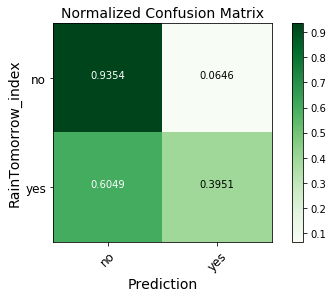


Summary Stats - Decision Tree

Precision = 0.7452667814113597
Recall = 0.4561255662066786
F1 Score = 0.5659021106972489
Confusion Matrix, without normalization
[[31455.  1480.]
 [ 5163.  4330.]]


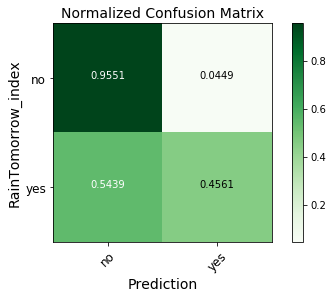

In [23]:
# present statistics
run_stats(dt_prediction, 'Decision Tree')
run_stats(rf_prediction, 'Random Forest')
run_stats(lr_prediction, 'Decision Tree')
run_stats(gbt_prediction, 'Decision Tree')

The statistics presented above demonstrate prediction behaviors of different models.

As can be seen in confusion matrix, different algorithms may be better for different directions.

Hence, it is necessary to combine all factors for analysis.


To improve the overall accuracy of the prediction, there are several methods can be conducted.

**Add more data**

Typically, more data for training and validation can improve the model accuracy and avoid over-fitting.

**Feature Selection**

Select the best subset of attributes that can better explain relationship with the target can enhance prediction behavior. It can be achieved by removing some attributes or adding to the dataset manually before training. 

For example, a set of attributes are dropped at the beginning, including 'Date', 'Location' and 'Cloud', which should be considered as vital variables.

**Algorithm Tuning**

It is necessary to find the optimum value for each parameter since the parameters can impact the model significantly. For example, the random forest model trained above only defines the number_tree=10. The accuracy may be improved by modifying the tree number or adding other parameters like max_features or others.

**Cross Validation**

To improve accuracy but avoid over-fitting, implement cross validation is important. Take the logistic regression as an example:

In [24]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="RainTomorrow_index", \
                                                     predictionCol="prediction", metricName="accuracy"),\
                          numFolds=2)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(trainingData)

# Make predictions on test documents. cvModel uses the best model found (lrModel).
prediction = cvModel.transform(testData)
selected = prediction.select("prediction", 'RainTomorrow_index')
print('Logistic regression before cross validation:')
multi_class_evaluate(lr_prediction)
print('Logistic regression after cross validation:')
multi_class_evaluate(selected)

Logistic regression before cross validation:
Prediction Accuracy = 81.4509%
Logistic regression after cross validation:
Prediction Accuracy = 81.5028%
